# Wildfire Classification

In [ ]:
### photo here ###

### Overview
Wildfires are highly unpredictable natural disasters. They can be sparked by a variety of factors (human carelessness, arson, lightning, etc.), and spread and behave differently based on a myriad of different “ingredients.” All wildfires start small, but any one of these risk factors can change at a moment’s notice taking a fire from small and almost contained, to unwieldy and catastrophic. The effects of global climate change have only exacerbated the factors we know to be conducive to large wildfires, namely heat, drought, and high winds. While wildfires can occur almost anywhere at any time, there are certainly circumstances that make a wildfire more threatening. 

### Business Case
According to the [National Interagency Fire Center (NIFC)](https://www.nifc.gov/), in the US we are experiencing not only more fires every year, but bigger, more destructive fires. Since 1999 the US has documented an average of more than 60,000 wildfires that total about 3 million acres burned per year. At peak season, wildfires become so prevalent that there are not enough resources or firefighters to tend to every single call (particularly in the Western half of the United States), forcing firefighters to make high stakes decisions about which fires are more likely to become the most dangerous. With this in mind we set out to classify wildfires as either "small" or "large" to automate this decision making process.

In [36]:
# normal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score

# feature selection
from sklearn.feature_selection import SelectKBest, RFECV, chi2, f_classif, mutual_info_classif

# class imbalance
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
 
import warnings
warnings.filterwarnings('ignore')
pd.pandas.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('data/forest_fire.csv')

### The Data
The [dataset](https://www.kaggle.com/capcloudcoder/us-wildfire-data-plus-other-attributes) was compiled on Kaggle from the Fort Collins, CO: Forest Service Research Data Archive about wildfires across the US (& PR) from 1992 - 2015, NOAA National Centers for Environmental Information, and supplemented from two other sources. **We wanted to create a highly interpretable, predictive model to help firefighters classify wildfires from less dangerous to more dangerous (small or large).** The National Wildfire Coordinating Group (NWCG) uses a retroactive [classification metric](https://www.nwcg.gov/term/glossary/size-class-of-fire#:~:text=As%20to%20size%20of%20wildfire,one%2Dfourth%20acre%20or%20less%3B&text=Class%20F%20%2D%201%2C000%20acres%20or,G%20%2D%205%2C000%20acres%20or%20more) of "A-G" where "A" is the smallest category burning anything under ¼ of an acre, and "G" being the largest class of fires burning a *minimum* of 5,000 acres. 

The dataset includes features about what caused a fire, weather conditions leading up to the start of the fire, and geographical data about the type of environment most prevalent at the site of a fire. If firefighters are able to forecast a fire's potential to become "large" based on these factors and a few that we engineered from the data, they will be able to make faster prioritizations and real-time decisions about where and when to allocate their limited resources.

In [3]:
# this block of code takes care of null values and unusable data
df = df[df['Temp_cont'] != -1]

to_drop = ['Unnamed: 0', 'Unnamed: 0.1', 'fire_name',
           'cont_clean_date', 'disc_date_final', 'cont_date_final', 
           'putout_time', 'disc_date_pre', 'disc_pre_year', 
           'disc_pre_month', 'wstation_usaf', 'dstation_m',
           'wstation_wban', 'wstation_byear', 'wstation_eyear',
           'fire_mag', 'weather_file', 'Temp_cont', 'Hum_cont',
           'Wind_cont', 'Prec_cont']

df = df.drop(labels=to_drop, axis=1)

# convert temperatures from C to F
def c_to_f(c):
    return (c * 9/5) + 32

df.loc[:,'Temp_pre_30':'Temp_pre_7'] = df.loc[:,'Temp_pre_30':'Temp_pre_7'].applymap(lambda x: c_to_f(x))

# remove rows where 'missing values' that have been replaced by 0C/32F
df = df[(df.Temp_pre_30!=float(32))]
df = df[(df.Temp_pre_15!=float(32))]
df = df[(df.Temp_pre_7!=float(32))]

# the target variable: 0 = fires less than 100 acres, 1 = fires bigger than 100 acres
df['target'] = np.where(df['fire_size'] <= 100,0,1)

df.shape

(36535, 23)

### Exploratory Data Analysis & Feature Engineering
To make this a binary classification problem, we separated the target variable `fire_size` into small fires (0, negative class), and large fires (1, positive class). The cutoff for these was fires classified as A, B, or C (i.e. less than 100 acres burned), and fires that burn larger than 100 acres. This left us with a fairly large class imbalance with about 84% of our data occurring in the negative class. This class imbalance varies from state to state, with large wildfires occurring at higher rates in the south and western parts of the US.

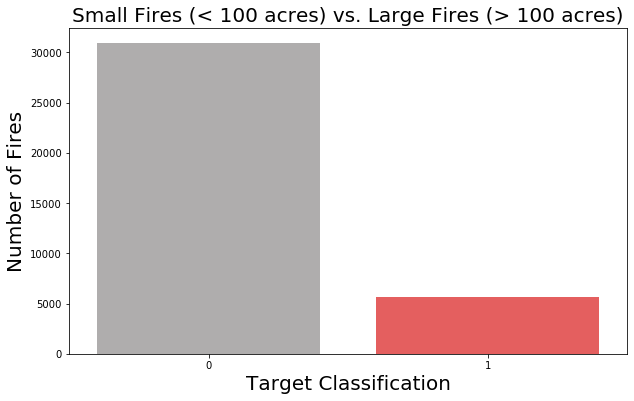

<Figure size 432x288 with 0 Axes>

In [5]:
colors = ['#AFADAD', '#FA4949']
plt.figure(figsize=(10,6))
sns.set_palette(sns.color_palette(colors))
sns.countplot(df['target'])
plt.title('Small Fires (< 100 acres) vs. Large Fires (> 100 acres)', fontsize=20)
plt.xlabel('Target Classification', fontsize=20)
plt.ylabel('Number of Fires', fontsize=20)
plt.show()
#plt.savefig('images/class_imbalance.png')

Despite this large class imbalance. It is important for us to identify the factors that make a fire riskier, because it goes without saying that riskier fires end up burning far more land than less risky fires. We see in the visual below how such **a small percentage of wildfires in the US burn an overwhelming majority of the acreage every year**.

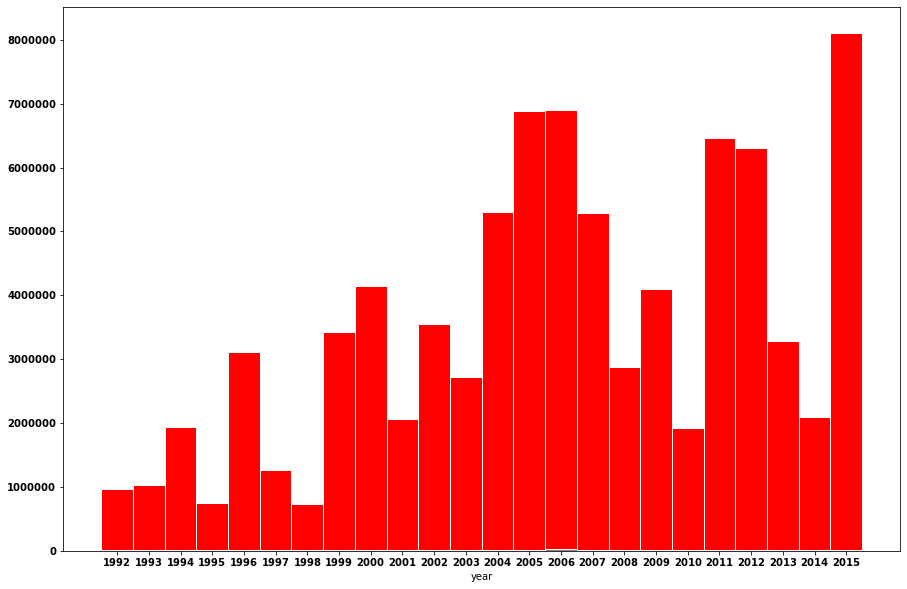

<Figure size 432x288 with 0 Axes>

In [7]:
# acres burned by year
df['year'] = df['disc_clean_date'].apply(lambda x: int(x[-4:]))

small_acres_df = df[df['target'] == 0]
small_acres = small_acres_df.groupby('year').fire_size.sum()

large_acres_df = df[df['target'] == 1]
large_acres = large_acres_df.groupby('year').fire_size.sum()

plt.figure(figsize=(15,10))
rc('font', weight='bold')

bars1 = list(small_acres)
bars2 = list(large_acres)

bars = np.add(bars1, bars2).tolist()

r = sorted(list(df['year'].unique()))

names = sorted(list(df['year'].unique()))

barWidth = 1

plt.bar(r, bars1, color='grey', edgecolor='white', width=barWidth)
plt.bar(r, bars2, bottom=bars1, color='red', edgecolor='white', width=barWidth)

plt.xticks(r, names, fontweight='bold')
plt.xlabel('year')

plt.show()
#plt.savefig('images/acres_by_year.png')

This scatter plot below maps out the locations of each instance in our dataset and labels the large fires red and the smaller fires grey. As is evident from the plot, the vast majority of our target class occur in the western United States, including and particularly in Alaska. We created a feature called `west_coast` to indicate whether a state is west of the -100 longitudinal line.

In [8]:
df['west_coast'] = df.longitude.apply(lambda x: 1 if x < -100 else 0)

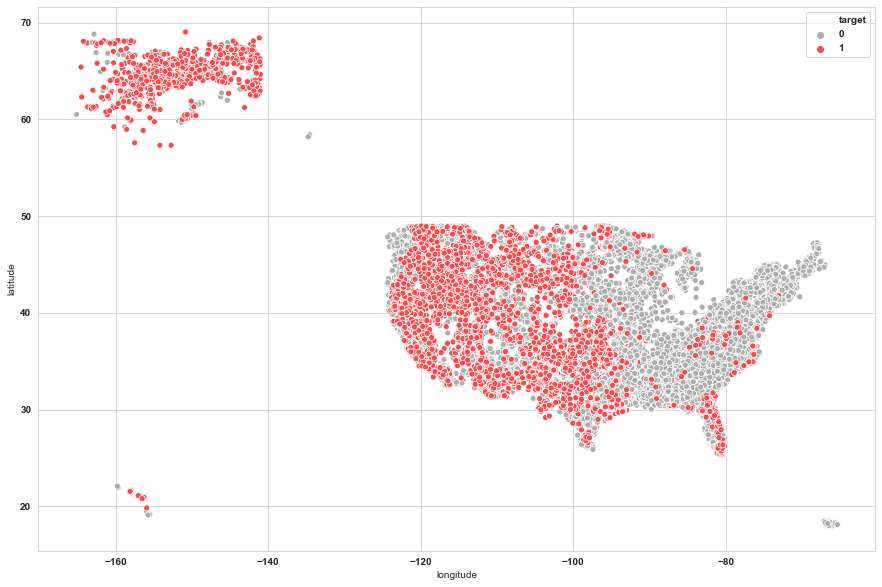

In [11]:
sns.set_style("whitegrid")

x = df.longitude
y = df.latitude

fig = plt.figure(figsize=(15,10))
ax = fig.subplots
ax = sns.scatterplot(x=x, y=y,
              hue=df.target,
              data=df,
              legend='full');
#plt.savefig('images/fire_map.png')

From what we hear and see on the news, we know that Summer is known as wildfire season on the West Coast. Summer evidently provides wildfires with the ideal conditions to thrive. This was reflected in our data. You see below that while there might not be more occurences of wildfires during the Summer, there are undoubtedly more "large" wildfires that take place in the Summer months of June, July, and August. With this data, along with a couple other categorical variables (`Vegetation` and `State`) we concatenated a dummy dataframe.

In [12]:
# parsing out the month
df['month'] = df['discovery_month'].apply(lambda x: 
                                         1 if x == 'Jan'
                                          else 2 if x == 'Feb'
                                          else 3 if x == 'Mar'
                                          else 4 if x == 'Apr'
                                          else 5 if x == 'May'
                                          else 6 if x == 'Jun'
                                          else 7 if x == 'Jul'
                                          else 8 if x == 'Aug'
                                          else 9 if x == 'Sep'
                                          else 10 if x == 'Oct'
                                          else 11 if x == 'Nov'
                                          else 12
                                         )

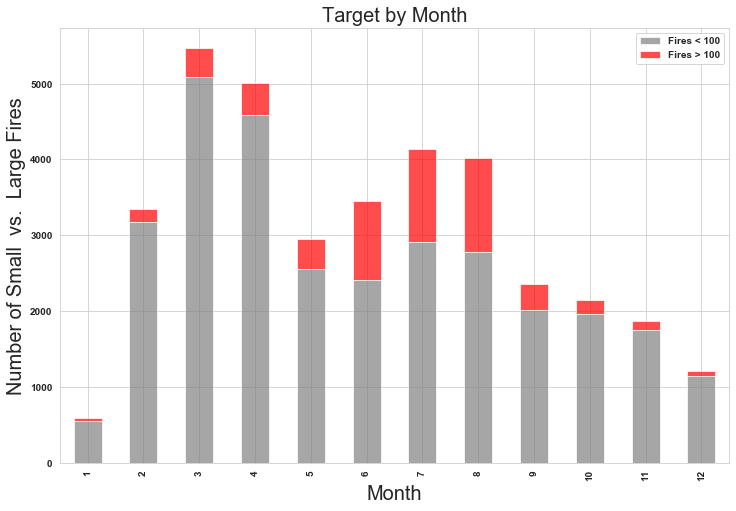

<Figure size 432x288 with 0 Axes>

In [15]:
month_viz = df.groupby(['month', 'target']).month.count().unstack()

p1 = month_viz.plot(kind='bar', stacked=True, color=['grey', 'red'], alpha=.70, figsize=(12,8))
p1.set_title('Target by Month', fontsize=20)
p1.set_xlabel('Month', fontsize=20)
p1.set_ylabel('Number of Small  vs.  Large Fires', fontsize=20)
p1.legend(['Fires < 100', 'Fires > 100'])
plt.show()
#plt.savefig('images/fires_by_month.png')

Talk about remoteness and why 0.6

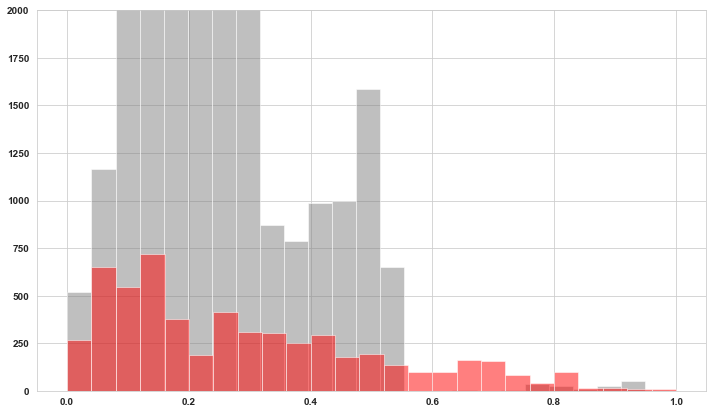

In [17]:
# remoteness graph
smalls = df[df['target'] == 0]
large = df[df['target'] == 1]

plt.figure(figsize=(12,7))
plt.hist(smalls['remoteness'], bins=25, alpha=0.5, label='Small Fires', color='grey')
plt.hist(large['remoteness'], bins=25, alpha=0.5, label='Large Fires', color='red')
plt.ylim(0,2000)
#plt.savefig('images/fire_remoteness.png')

Talk about cause of fires and lightning

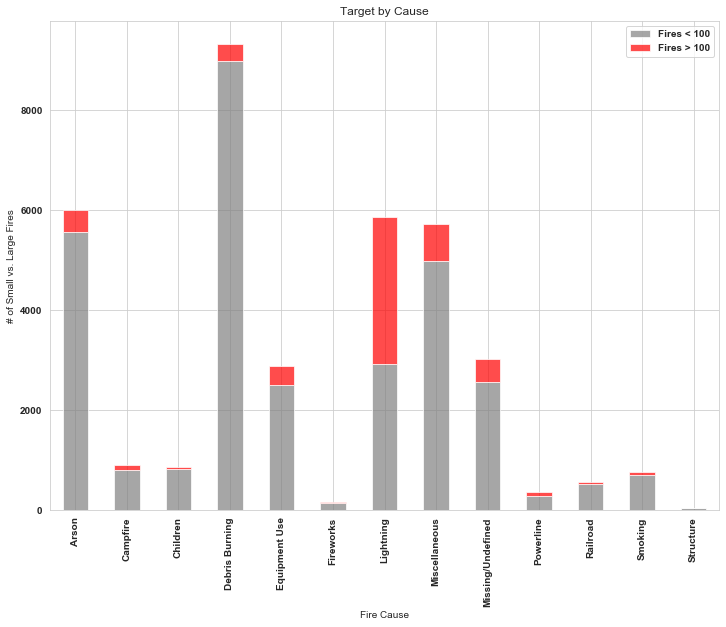

In [20]:
# cause of fire graph (highlights lightning)
cause_viz = df.groupby(['stat_cause_descr', 'target']).stat_cause_descr.count().unstack()

p2 = cause_viz.plot(kind='bar', stacked=True, title='Target by Cause', color=['grey', 'red'], alpha=.70, figsize=(12,9))
p2.set_xlabel('Fire Cause')
p2.set_ylabel('# of Small vs. Large Fires')
p2.legend(['Fires < 100', 'Fires > 100'])
plt.show()
#plt.savefig('images/fire_by_cause.png')

In [29]:
df = pd.read_csv('data/cleaned_fire_data.csv')

In [30]:
df = df.drop(columns='Unnamed: 0',axis=1)

In [31]:
# Creating Feature data frame and Target data frame
X = df.drop(columns='target',axis=1)
y = df['target']

# Creating Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Feature Selection with Filter Method

In [33]:
# instantiating a feature selector object
feature_selector = SelectKBest(mutual_info_classif,15)

# fitting to our data
feature_selector.fit(X_train,y_train)

# features that we keep
selected_filter = X_train.columns[feature_selector.get_support()]

In [34]:
list(selected_filter)

['latitude',
 'longitude',
 'Temp_pre_30',
 'Temp_pre_7',
 'Hum_pre_30',
 'Hum_pre_15',
 'Hum_pre_7',
 'remoteness',
 'month',
 'temp_avg',
 'longitude_bin',
 'west_coast',
 'low_humid_30',
 'low_humid_15',
 'low_humid_7']

In [35]:
X_train = X_train[selected_filter]
X_test = X_test[selected_filter]

### Smote for balancing class

In [37]:
# creating synthetic rows using SMOTE
sm = SMOTE(random_state=99)
X_train_smote, y_train_smote = sm.fit_sample(X_train,y_train)

### Decision Tree

In [39]:
# create tree using grid searched hyper parameters
tree = DecisionTreeClassifier(max_depth=10, max_leaf_nodes=43, min_samples_split=2)
# fitting the tree
tree = tree.fit(X_train, y_train)
# predicting on the train
pred_train = tree.predict(X_train)
# predicting on test
pred_test = tree.predict(X_test)

# scores
test_f1 = f1_score(y_test,pred_test)
test_acc = accuracy_score(y_test, pred_test)
test_recall = recall_score(y_test, pred_test)
test_precision = precision_score(y_test,pred_test)
print('Train F1: ', f1_score(y_train, pred_train))
print('Test F1: ', f1_score(y_test, pred_test), '\n')
print('Train Accuracy: ', accuracy_score(y_train, pred_train))
print('Test Accuracy: ', accuracy_score(y_test, pred_test), '\n')
print('Train Recall: ', recall_score(y_train, pred_train))
print('Test Recall: ', recall_score(y_test, pred_test), '\n')
print('Train Precision: ', precision_score(y_train, pred_train))
print('Test Precision: ', precision_score(y_test, pred_test))

Train F1:  0.8203296703296704
Test F1:  0.8208636169303122 

Train Accuracy:  0.9522645158935805
Test Accuracy:  0.9541274359535801 

Train Recall:  0.6997890789782049
Test Recall:  0.7064017660044151 

Train Precision:  0.9910388317291736
Test Precision:  0.9795918367346939


### XGBoost

In [41]:
xg_clf = xgb.XGBClassifier(objective ='binary:logistic', 
                           colsample_bytree = 0.5, 
                           min_child_weight = 5,
                           learning_rate = 0.1,
                           max_depth = 5, 
                           n_estimators = 500)

xg_clf.fit(X_train,y_train)

XGBClassifier(colsample_bytree=0.5, max_depth=5, min_child_weight=5,
              n_estimators=500)

In [42]:
preds_train = xg_clf.predict(X_train)

preds_test = xg_clf.predict(X_test)

# scores
test_f1 = f1_score(y_test,pred_test)
test_acc = accuracy_score(y_test, pred_test)
test_recall = recall_score(y_test, pred_test)
test_precision = precision_score(y_test,pred_test)
print('Train F1: ', f1_score(y_train, pred_train))
print('Test F1: ', f1_score(y_test, pred_test), '\n')
print('Train Accuracy: ', accuracy_score(y_train, pred_train))
print('Test Accuracy: ', accuracy_score(y_test, pred_test), '\n')
print('Train Recall: ', recall_score(y_train, pred_train))
print('Test Recall: ', recall_score(y_test, pred_test), '\n')
print('Train Precision: ', precision_score(y_train, pred_train))
print('Test Precision: ', precision_score(y_test, pred_test))

Train F1:  0.8203296703296704
Test F1:  0.8208636169303122 

Train Accuracy:  0.9522645158935805
Test Accuracy:  0.9541274359535801 

Train Recall:  0.6997890789782049
Test Recall:  0.7064017660044151 

Train Precision:  0.9910388317291736
Test Precision:  0.9795918367346939


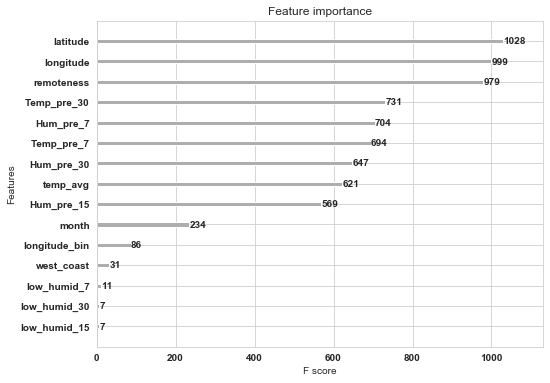

<Figure size 576x432 with 0 Axes>

In [45]:
xgb.plot_importance(xg_clf,max_num_features = 15)
plt.rcParams['figure.figsize'] = [8, 6]
plt.show()
#plt.savefig('images/feature_importance.png')